# NTNU fish dataset processing

## Dataset Setup

Using the NTNU-setup

- Place the .zip in the data folder
- Then unzip it manually or running code below:
    - Delete _MACOSX folder if this also were addded.
    - Inside FishDataset, Delete data.yaml, Delete Compiled Online Data ...  .txt

In [ ]:
# import zipfile
# import os

# zip_path = "../data/NTNU_fish.zip"
# extract_dir = "../data/"

# # Make sure the target directory exists
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print("✅ FishDatas etextracted to:", os.path.abspath(extract_dir))


✅ FishDatas etextracted to: /Users/henrik/kode/SP/uw_yolov8/data


### Make config file

In [1]:
from pathlib import Path

# Base paths
NOT_ROOT = Path.cwd()
ROOT = NOT_ROOT.parent

DATA = ROOT / "data" / "FishDataset"

IMAGES_TRAIN = DATA / "train" / "images"
IMAGES_VAL   = DATA / "val"   / "images"
IMAGES_TEST  = DATA / "test"  / "images"

# Build YAML (classic YOLO: train/val/test point to images dirs)
dataset_yaml = f"""
path: {DATA.as_posix()}
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}

nc: 1
names: ['fish']
"""

# Write YAML next to the dataset
yaml_path = DATA / "fishdataset.yaml"
yaml_path.write_text(dataset_yaml.strip() + "\n", encoding="utf-8")

print("Wrote:", yaml_path)
print("\nPreview:\n")
print(dataset_yaml)


Wrote: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/fishdataset.yaml

Preview:


path: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset
train: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/train/images
val:   /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/val/images
test:  /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/test/images

nc: 1
names: ['fish']



## Validate data

In [3]:
from pathlib import Path
from collections import Counter, defaultdict
import json
import yaml

# -------- Settings --------
ENABLE_IMAGE_SIZE_STATS = False  # set True to also compute min/mean/max sizes (slower)
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    SCRIPT_DIR = Path.cwd()

# Project root is one level up from utils/
ROOT = SCRIPT_DIR.parent
DATA = ROOT / "data" / "FishDataset"

def load_class_names(data_dir: Path):
    yaml_path = data_dir / "data.yaml"
    if yaml_path.exists():
        try:
            cfg = yaml.safe_load(yaml_path.read_text(encoding="utf-8"))
            names = cfg.get("names")
            # names can be list or dict {id:name}
            if isinstance(names, dict):
                # convert to index-ordered list
                max_idx = max(int(k) for k in names.keys())
                arr = [""] * (max_idx + 1)
                for k, v in names.items():
                    arr[int(k)] = str(v)
                return arr
            elif isinstance(names, list):
                return [str(n) for n in names]
        except Exception:
            pass
    # fallback (your current dataset has 1 class: fish)
    return ["fish"]

def list_images(images_dir: Path):
    return sorted([p for p in images_dir.rglob("*") if p.suffix.lower() in IMAGE_EXTS])

def list_labels(labels_dir: Path):
    return sorted([p for p in labels_dir.rglob("*.txt")])

def safe_float(x):
    try:
        float(x)
        return True
    except Exception:
        return False

def scan_split(split_dir: Path, class_names):
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"

    imgs = list_images(images_dir) if images_dir.exists() else []
    lbls = list_labels(labels_dir) if labels_dir.exists() else []

    img_stems = {p.stem for p in imgs}
    lbl_stems = {p.stem for p in lbls}

    images_without_labels = sorted([p.as_posix() for p in imgs if p.stem not in lbl_stems])
    labels_without_images = sorted([p.as_posix() for p in lbls if p.stem not in img_stems])

    # Parse labels
    instance_count = 0
    class_counter = Counter()
    invalid_lines = []

    for lp in lbls:
        with lp.open("r", encoding="utf-8") as f:
            for i, line in enumerate(f, start=1):
                line = line.strip()
                if not line or line.startswith("#"):
                    continue
                parts = line.split()
                if len(parts) < 5 or not parts[0].isdigit() or not all(safe_float(x) for x in parts[1:5]):
                    invalid_lines.append(f"{lp.as_posix()}:{i} -> {line}")
                    continue
                cls_id = int(parts[0])
                class_counter[cls_id] += 1
                instance_count += 1

    size_stats = {}
    if ENABLE_IMAGE_SIZE_STATS:
        try:
            from PIL import Image
            widths, heights = [], []
            for p in imgs:
                try:
                    with Image.open(p) as im:
                        w, h = im.size
                        widths.append(w); heights.append(h)
                except Exception:
                    # Skip unreadable images
                    pass
            if widths and heights:
                import statistics as stats
                size_stats = {
                    "count_measured": len(widths),
                    "width_min": min(widths), "width_max": max(widths), "width_mean": round(stats.mean(widths), 2),
                    "height_min": min(heights), "height_max": max(heights), "height_mean": round(stats.mean(heights), 2),
                }
        except ImportError:
            size_stats = {"note": "Pillow not installed; set ENABLE_IMAGE_SIZE_STATS=True after `pip install pillow`"}

    # Map class ids to names
    id2name = {i: (class_names[i] if i < len(class_names) else f"class_{i}") for i in class_counter.keys()}
    class_breakdown = {id2name[i]: class_counter[i] for i in sorted(class_counter.keys())}

    return {
        "images_dir": images_dir.as_posix(),
        "labels_dir": labels_dir.as_posix(),
        "num_images": len(imgs),
        "num_labels": len(lbls),
        "images_without_labels": images_without_labels,
        "labels_without_images": labels_without_images,
        "instances_total": instance_count,
        "instances_per_class": class_breakdown,
        "invalid_label_lines": invalid_lines[:50],  # preview first 50
        "invalid_label_lines_count": len(invalid_lines),
        "image_size_stats": size_stats,
    }

def main():
    if not DATA.exists():
        raise SystemExit(f"Dataset not found at: {DATA.as_posix()}")

    class_names = load_class_names(DATA)

    report = {"dataset_root": DATA.as_posix(), "classes": class_names, "splits": {}}
    for split in ["train", "val", "test"]:
        split_dir = DATA / split
        if split_dir.exists():
            report["splits"][split] = scan_split(split_dir, class_names)
        else:
            report["splits"][split] = {"note": f"{split} split not found"}

    # Print a friendly summary
    print("\n================ DATASET SUMMARY ================\n")
    print(f"Root: {report['dataset_root']}")
    print(f"Classes ({len(class_names)}): {class_names}\n")

    grand_images = grand_labels = grand_instances = 0
    for split, info in report["splits"].items():
        if "note" in info:
            print(f"[{split.upper()}] {info['note']}\n")
            continue
        print(f"[{split.upper()}]")
        print(f"  images dir: {info['images_dir']}")
        print(f"  labels dir: {info['labels_dir']}")
        print(f"  #images: {info['num_images']:,}")
        print(f"  #labels: {info['num_labels']:,}")
        print(f"  #instances: {info['instances_total']:,}")
        if info["instances_per_class"]:
            print(f"  per-class: {info['instances_per_class']}")
        if info["images_without_labels"]:
            print(f"  images without labels: {len(info['images_without_labels'])} (showing up to 5)")
            for p in info["images_without_labels"][:5]:
                print(f"    - {p}")
        if info["labels_without_images"]:
            print(f"  labels without images: {len(info['labels_without_images'])} (showing up to 5)")
            for p in info["labels_without_images"][:5]:
                print(f"    - {p}")
        if info["invalid_label_lines_count"] > 0:
            print(f"  invalid label lines: {info['invalid_label_lines_count']} (showing up to 5)")
            for ln in info["invalid_label_lines"][:5]:
                print(f"    - {ln}")
        if info["image_size_stats"]:
            print(f"  image size stats: {info['image_size_stats']}")
        print()
        grand_images += info.get("num_images", 0)
        grand_labels += info.get("num_labels", 0)
        grand_instances += info.get("instances_total", 0)

    print("--------------- TOTALS ---------------")
    print(f"Total images:    {grand_images:,}")
    print(f"Total labels:    {grand_labels:,}")
    print(f"Total instances: {grand_instances:,}")
    print("\n===============================================\n")

    # Save a machine-readable copy
    # out_json = DATA / "dataset_stats.json"
    # out_json.write_text(json.dumps(report, indent=2), encoding="utf-8")
    # print(f"Saved JSON report to: {out_json.as_posix()}")

if __name__ == "__main__":
    main()



================ DATASET SUMMARY ================

Root: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset
Classes (1): ['fish']

[TRAIN]
  images dir: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/train/images
  labels dir: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/train/labels
  #images: 17,956
  #labels: 17,956
  #instances: 43,890
  per-class: {'fish': 43890}

[VAL]
  images dir: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/val/images
  labels dir: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/val/labels
  #images: 5,130
  #labels: 5,130
  #instances: 12,103
  per-class: {'fish': 12103}

[TEST]
  images dir: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/test/images
  labels dir: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/FishDataset/test/labels
  #images: 2,566
  #labels: 2,566
  #instances: 5,721
  per-class: {'fish': 5721}

--------------- TOTALS ---------------
Total images:    25,6

## Visualize data

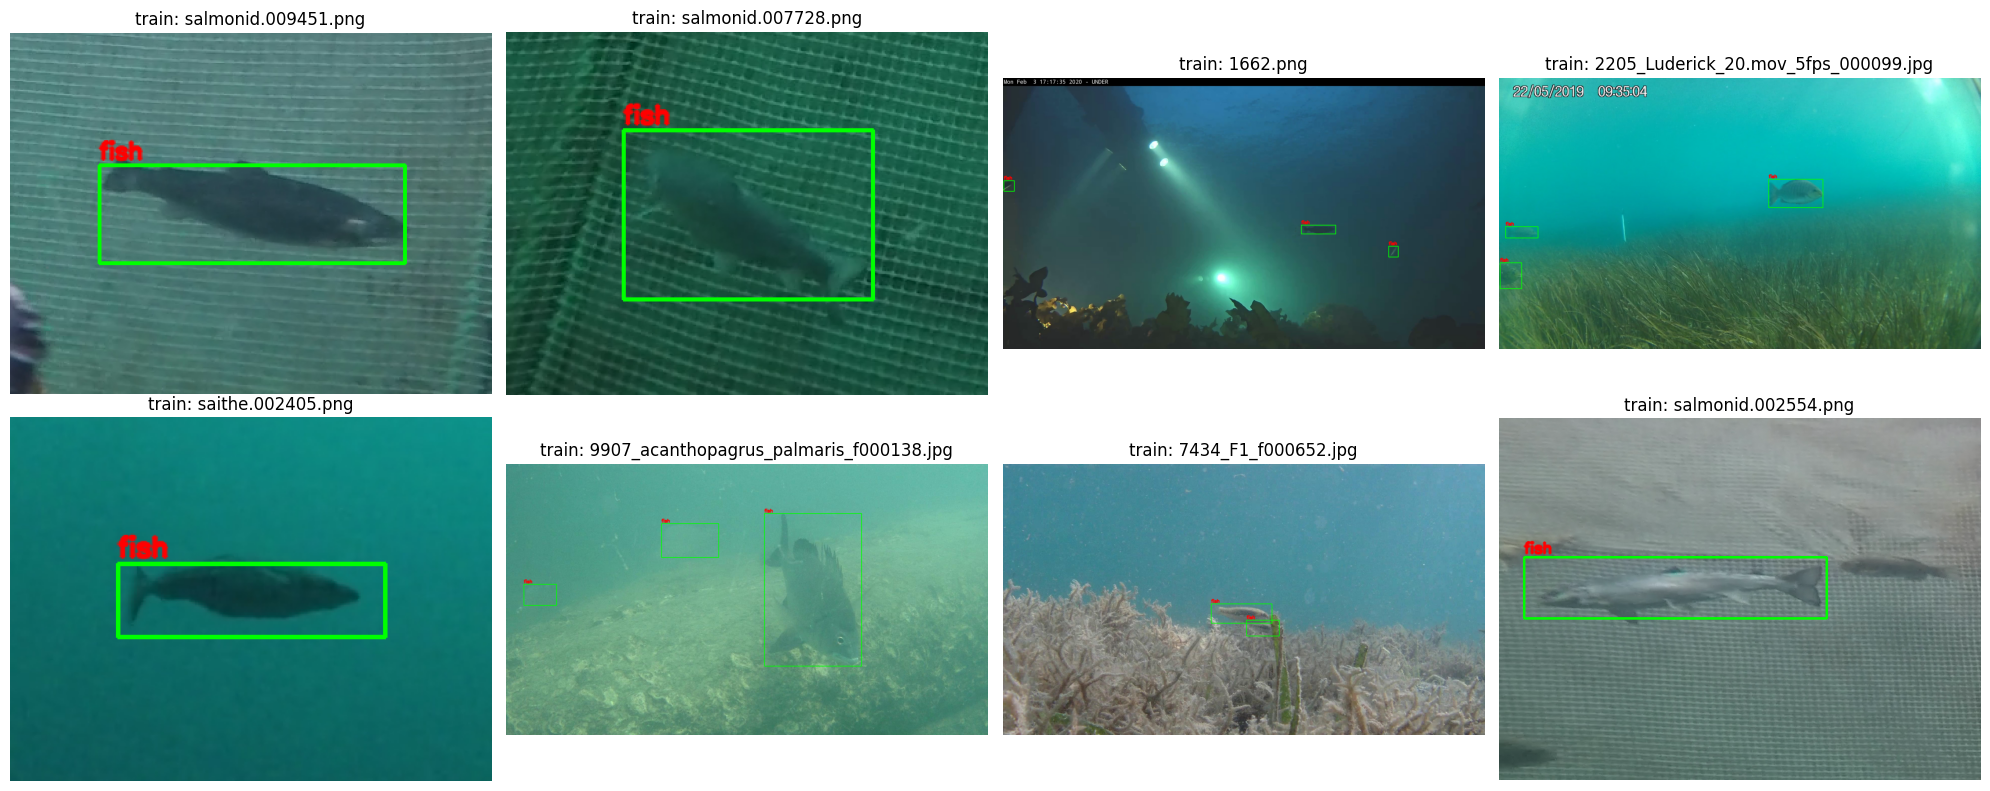

In [4]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# ---------- config (edit if you like) ----------
DATA_ROOT = Path("../data/FishDataset")
SPLIT = "train"   # "train", "val", or "test"

IMG_DIR = DATA_ROOT / SPLIT / "images"
LAB_DIR = DATA_ROOT / SPLIT / "labels"

YAML_PATH = DATA_ROOT / "fishdataset.yaml"   # optional, to read class names

NUM_PICS = 8
COLS = 4
# ----------------------------------------------

# Try to read class names from the YAML (YOLO-style)
def load_names_from_yaml(yaml_path: Path):
    try:
        import yaml
        if yaml_path.exists():
            y = yaml.safe_load(yaml_path.read_text())
            # names can be a dict {id:name} or list [name0, name1, ...]
            names = y.get("names")
            if isinstance(names, dict):
                # ensure list order by id
                max_id = max(int(k) for k in names.keys())
                lst = [""] * (max_id + 1)
                for k, v in names.items():
                    lst[int(k)] = str(v)
                return lst
            if isinstance(names, list):
                return [str(n) for n in names]
    except Exception as e:
        print(f"Could not load names from YAML ({e}). Using generic labels.")
    return None

NAMES = load_names_from_yaml(YAML_PATH) or [f"class{i}" for i in range(100)]  # safety net

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        try:
            cls = int(float(parts[0]))
            cx, cy, bw, bh = map(float, parts[1:5])
        except:
            continue

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        # green box, red text (OpenCV uses BGR)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        label = names[cls] if 0 <= cls < len(names) and names[cls] else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images (prefer ones with labels if available)
if not IMG_DIR.is_dir():
    raise FileNotFoundError(f"Images folder not found: {IMG_DIR}")
if not LAB_DIR.is_dir():
    print(f"⚠️ Labels folder not found: {LAB_DIR} (will show images without boxes)")

all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()
